In [1]:
import numpy as np
import edf
from time import time
import sys

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
traindata = './mnist_data/train.npz'
valdata = './mnist_data/test.npz'

data = np.load(traindata)
t_imgs = np.float32(data['imgs'])/255.
t_labels = np.float32(data['labels'])

data = np.load(valdata)
v_imgs = np.float32(data['imgs'])/255.
v_labels = np.float32(data['labels'])

## Explore Different Optimization Algorithms

### Standard SGD

Standard SGD just updates the value of the parameter based on the loss $$ \mathrm{\Theta}_{t+1} = \mathrm{\Theta}_{t} - \eta \ell(\Theta) $$

### Momentum SGD

Moment SGD updates the parameters with a viscous moment decay. The moment is equavalent to the parameter update divided by the learning rate $\eta$
$$ \Theta_{t+1} = \Theta_{t} - \eta \, g_{t + 1} .$$

The momentum is updated with a decay constant $\mu$. You can think of this decay constant as viscosity or a forgetting constant between time-steps. The gradient of the loss is injected into the momentum just like Newtonian mechanics of a massive billard ball rolling down a slope $$g_{t+1} = \mu g_t + (1-\mu) \nabla_\Theta \ell_t(\Theta) .$$ 

### Adam

Adam standands for "Adaptive Moment Estimation". The update rule is a more elaborate variant of the moment SGD. It basically an improvement of RMSProp using ideas of Momentum SGD. The intuition is that when the gradient is more rough, the moment should be updated more quickly (RMSProp), and the gradient should be updated gradually (Momentum in previous section). Below is the update rule

$$\begin{align}
 g' &= \beta_1 g + (1-\beta_1) \nabla \\
\Theta &= \Theta - \frac{\eta}{\mathrm{blah}} g'
\end{align}$$

what is $blah$ then? $$\mathrm{blah} = \sqrt{s} + \epsilon$$ where $$s = \beta_2 s + (1-\beta_2) \nabla^2.$$


More detailed explaination of Adam can be seen in the original proposal [Kingma 2015](https://arxiv.org/pdf/1412.6980.pdf). 

### RMSProp

you can compare Adam with RMSProp: 
$$
\Theta = \Theta - \frac{\eta}{\mathrm{blah}} \nabla
$$ where $$\mathrm{blah} = \sqrt{s} + \epsilon$$ where $$s = \beta_2 s + (1-\beta_2) \nabla^2.$$

The difference is only in the momentum in the update function for $\Theta$. The rest is the same.


In [3]:
def batch_SGD(batch = 50, eta = 0.37, verbose=True):
    # to clear the globals in `edf`
    edf.components = []
    edf.params = []


    ######################################### please modify this cell to finish the problem 2.a #######################
    # for repeatability
    np.random.seed(0)

    # Inputs and parameters
    inp = edf.Value()
    lab = edf.Value()

    W1 = edf.Param(edf.xavier((28*28,128)))
    B1 = edf.Param(np.zeros((128)))
    W2 = edf.Param(edf.xavier((128,10)))
    B2 = edf.Param(np.zeros((10)))

    # models
    hidden = edf.RELU(edf.Add(edf.VDot(inp,W1),B1))
    pred = edf.SoftMax(edf.Add(edf.VDot(hidden,W2),B2))
    loss = edf.LogLoss(edf.Aref(pred, lab))
    acc = edf.Accuracy(pred,lab)

    # evaluate the random performance
    def eval(imgs, labels):

        batches = range(0, len(labels), batch)
        objective = 0
        accuracy = 0
        for k in batches:
            inp.set(imgs[k:k+batch])
            lab.set(labels[k:k+batch])
            edf.Forward()
            objective += np.mean(loss.value)
            accuracy += acc.value

        return accuracy/len(batches), objective/len(batches)


    accuracy, objective = eval(t_imgs, t_labels)
    if verbose: print("Random accuracy = %.4f" % accuracy)

    # train loop
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    ep = 0
    stime = time()
    epoch = 10
    batches = range(0, len(t_labels), batch)

    while ep < epoch:

        # randon shuffle the train data in each epoch
        perm = np.random.permutation(len(t_labels))
        for k in batches:    
            inp.set(t_imgs[perm[k:k+batch]])
            lab.set(t_labels[perm[k:k+batch]])
            edf.Forward()
            edf.Backward(loss)
            edf.SGD(eta)

        # evaluate on trainset
        t_acc, t_loss = eval(t_imgs, t_labels)
        if verbose: print("Epoch %d: train loss = %.4f [%.4f secs]" % (ep, t_loss,time()-stime))
        train_loss.append(t_loss)
        train_acc.append(t_acc)

        # evaluate on testset
        v_acc, v_loss = eval(v_imgs, v_labels)
        if verbose: print("test accuracy=%.5f" % v_acc)
        test_loss.append(v_loss)
        test_acc.append(v_acc)
        stime = time()
        ep += 1
        
    return train_loss, train_acc, test_loss, test_acc

In [4]:
def plot_result(result, title=None, show_legend=True):

    train_loss, train_acc, test_loss, test_acc = result
    
    if title: plt.title(title)
    
    plt.xlabel("epochs")
    plt.ylabel("error")
    plt.plot(np.arange(len(test_acc)), 1 - np.array(test_acc),  'ro-',  mec="none")
    plt.plot(np.arange(len(train_acc)), 1 - np.array(train_acc),  'bo-',  mec="none")
    if show_legend: plt.legend(['test error',  'train error'],  loc='upper right',  frameon=False)
    plt.ylim(0, 0.08)

In [5]:
eta_start = lambda B: 0.0056*B + 0.0659

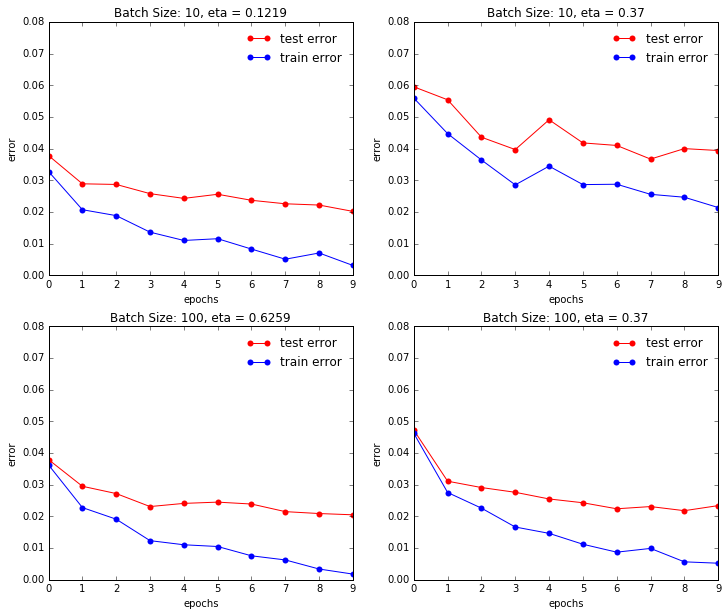

In [6]:
plt.figure(figsize=(12, 10))
result = batch_SGD(10, eta_start(10), verbose=False)
plt.subplot(221)
plot_result(result, "Batch Size: {}, eta = {}".format(10, eta_start(10)))
result = batch_SGD(10, 0.37, verbose=False)
plt.subplot(222)
plot_result(result, "Batch Size: {}, eta = {}".format(10, 0.37))
result = batch_SGD(100, eta_start(100), verbose=False)
plt.subplot(223)
plot_result(result, "Batch Size: {}, eta = {}".format(100, eta_start(100)))
result = batch_SGD(100, 0.37, verbose=False)
plt.subplot(224)
plot_result(result, "Batch Size: {}, eta = {}".format(100, 0.37))
plt.show()

## Momentum SGD Implementation

In [7]:
################### please modify this cell to finish the problem 2.b #########################################

def batch_moment_SGD(batch = 50, eta = 0.37, mu=0.55, verbose=True):
    
    # to clear the globals in `edf`
    edf.components = []
    edf.params = []
    
    # Optimization functions with Momentum algorithm, eta is learning rate and mom is momentum rate
    # please implement this function
    def Momentum(eta, mu = 0.55):

        # Initialize the "grad_hist" variable to memorize the history of gradient
        if 'grad_hist' not in edf.params[0].__dict__.keys():
            for p in edf.params:
                p.grad_hist = edf.DT(0)

        # please add code here to finish the function
        for p in edf.params:
            p.grad_hist = mu * p.grad_hist + (1 - mu) * p.grad
            p.value = p.value - eta * p.grad_hist
            p.grad = edf.DT(0)

    # for repeatability
    np.random.seed(0)

    # Inputs and parameters
    inp = edf.Value()
    lab = edf.Value()

    W1 = edf.Param(edf.xavier((28*28,128)))
    B1 = edf.Param(np.zeros((128)))
    W2 = edf.Param(edf.xavier((128,10)))
    B2 = edf.Param(np.zeros((10)))

    # models
    hidden = edf.RELU(edf.Add(edf.VDot(inp,W1),B1))
    pred = edf.SoftMax(edf.Add(edf.VDot(hidden,W2),B2))
    loss = edf.LogLoss(edf.Aref(pred,lab))
    acc = edf.Accuracy(pred,lab)

    # evaluate the random performance
    def eval(imgs, labels):

        batches = range(0, len(labels), batch)
        objective = 0
        accuracy = 0
        for k in batches:
            inp.set(imgs[k:k+batch])
            lab.set(labels[k:k+batch])
            edf.Forward()
            objective += np.mean(loss.value)
            accuracy += acc.value

        return accuracy/len(batches), objective/len(batches)


    accuracy, objective = eval(t_imgs, t_labels)
    if verbose: print("Random accuracy = %.4f" % accuracy)

    # train loop
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    ep = 0
    stime = time()
    epoch = 10
    batches = range(0, len(t_labels), batch)

    while ep < epoch:

        # randon shuffle the train data in each epoch
        perm = np.random.permutation(len(t_labels))
        for k in batches:    
            inp.set(t_imgs[perm[k:k+batch]])
            lab.set(t_labels[perm[k:k+batch]])
            edf.Forward()
            edf.Backward(loss)

            # here, we use Momentum to optimize as in problem 2.b
            Momentum(eta, mu)

        # evaluate on trainset
        t_acc, t_loss = eval(t_imgs, t_labels)
        if verbose: print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep, t_loss,time()-stime))
        train_loss.append(t_loss)
        train_acc.append(t_acc)

        # evaluate on testset
        v_acc, v_loss = eval(v_imgs, v_labels)
        if verbose: print("test accuracy=%.4f" % v_acc)
        test_loss.append(v_loss)
        test_acc.append(v_acc)
        stime = time()
        ep += 1
    
    return train_loss, train_acc, test_loss, test_acc

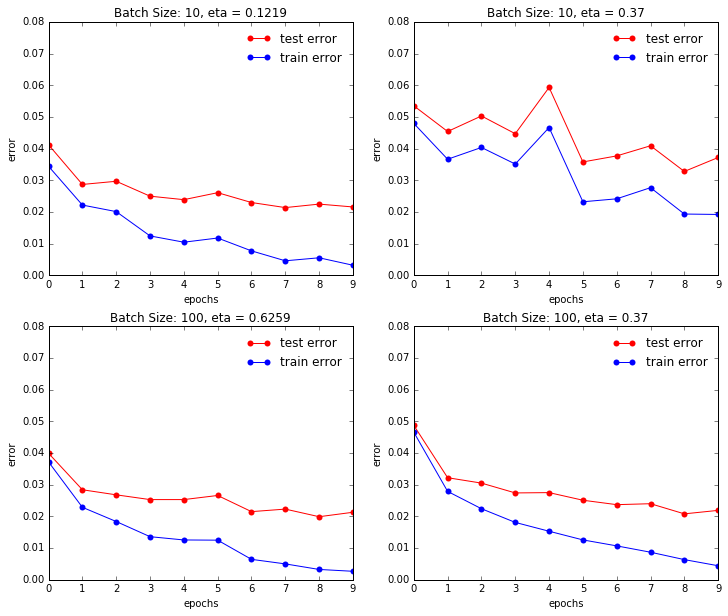

In [8]:
plt.figure(figsize=(12, 10))
result = batch_moment_SGD(10, eta_start(10), 0.55, verbose=False)
plt.subplot(221)
plot_result(result, "Batch Size: {}, eta = {}".format(10, eta_start(10)))
result = batch_moment_SGD(10, 0.37, 0.55, verbose=False)
plt.subplot(222)
plot_result(result, "Batch Size: {}, eta = {}".format(10, 0.37))
result = batch_moment_SGD(100, eta_start(100), 0.55, verbose=False)
plt.subplot(223)
plot_result(result, "Batch Size: {}, eta = {}".format(100, eta_start(100)))
result = batch_moment_SGD(100, 0.37, 0.55, verbose=False)
plt.subplot(224)
plot_result(result, "Batch Size: {}, eta = {}".format(100, 0.37))
plt.show()

## Adam Implementation

In [9]:
################### please modify this cell to finish the problem 2.c #########################################

def batch_Adam(batch = 50, eta = 0.37, b1=0.9, b2=0.999, eps=1e-8, verbose=True):
    
    # to clear the globals in `edf`
    edf.components = []
    edf.params = []
    

    # Optimization functions with Adam optimization algorithm.
    # For details, please see: https://arxiv.org/abs/1412.6980, 
    # Please implement this function

    # some constant used in Adam
    
    def Adam(eta=0.001, b1 = 0.9, b2 = 0.999, eps=1e-8):

        # Initialize the "grad_hist" variable to memorize the history of gradient
        # # Initialize the "grad_h2" variable to memorize the history of gradient variance
        if 'grad_hist' not in edf.params[0].__dict__.keys():
            for p in edf.params:
                p.grad_hist = edf.DT(0)
                p.grad_h2 = edf.DT(0)
        
        # please finish this function
        for p in edf.params:
            
            p.grad_hist = b1 * p.grad_hist + (edf.DT(1.0) - b1) * p.grad
            p.grad_h2 = b2 * p.grad_h2 + (edf.DT(1.0) - b2) * p.grad**2
            
            p.value -= eta*p.grad_hist/(np.sqrt(p.grad_h2) + eps)
            p.grad = edf.DT(0)
            
    # for repeatability
    np.random.seed(0)

    # Inputs and parameters
    inp = edf.Value()
    lab = edf.Value()

    W1 = edf.Param(edf.xavier((28*28,128)))
    B1 = edf.Param(np.zeros((128)))
    W2 = edf.Param(edf.xavier((128,10)))
    B2 = edf.Param(np.zeros((10)))

    # models
    hidden = edf.RELU(edf.Add(edf.VDot(inp,W1),B1))
    pred = edf.SoftMax(edf.Add(edf.VDot(hidden,W2),B2))
    loss = edf.LogLoss(edf.Aref(pred,lab))
    acc = edf.Accuracy(pred,lab)

    # evaluate the random performance
    def eval(imgs, labels):

        batches = range(0, len(labels), batch)
        objective = 0
        accuracy = 0
        for k in batches:
            inp.set(t_imgs[k:k+batch])
            lab.set(t_labels[k:k+batch])
            edf.Forward()
            objective += np.mean(loss.value)
            accuracy += acc.value

        return accuracy/len(batches), objective/len(batches)


    accuracy, objective = eval(t_imgs, t_labels)
    if verbose: print("Random accuracy = %.4f" % accuracy)

    # train loop
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    ep = 0
    stime = time()
    epoch = 10
    batches = range(0, len(t_labels), batch)

    while ep < epoch:

        # randon shuffle the train data in each epoch
        perm = np.random.permutation(len(t_labels))
        for k in batches:    
            inp.set(t_imgs[perm[k:k+batch]])
            lab.set(t_labels[perm[k:k+batch]])
            edf.Forward()
            edf.Backward(loss)

            # here, we use Adam algorithm to optimize as in problem 2.c
            Adam(eta)

        # evaluate on trainset
        t_acc, t_loss = eval(t_imgs, t_labels)
        if verbose: print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep, t_loss,time()-stime))
        train_loss.append(t_loss)
        train_acc.append(t_acc)

        # evaluate on testset
        v_acc, v_loss = eval(v_imgs, v_labels)
        if verbose: print("test accuracy=%.4f" % v_acc)
        test_loss.append(v_loss)
        test_acc.append(v_acc)
        stime = time()
        ep += 1
  
    return train_loss, train_acc, test_loss, test_acc

New optimal training $\eta$ is 0.0015/batch. 

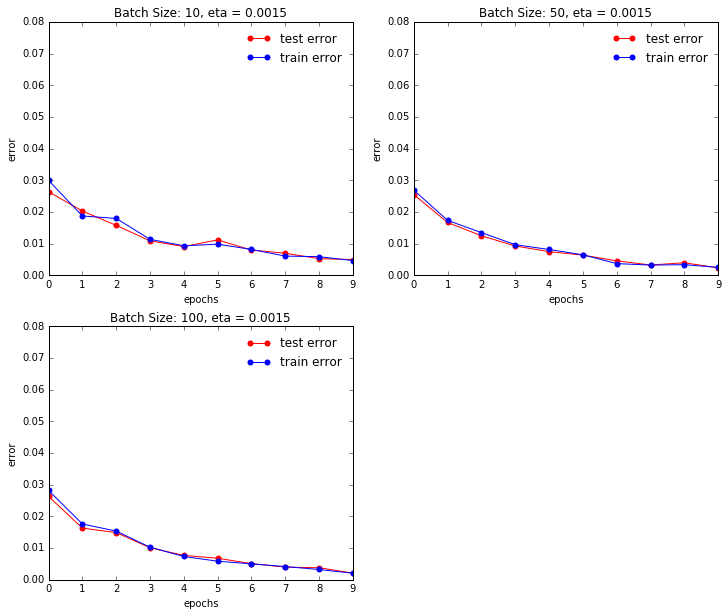

In [10]:
plt.figure(figsize=(12, 10))

result = batch_Adam(10, 0.0015, verbose=False)
plt.subplot(221)
plot_result(result, "Batch Size: {}, eta = {}".format(10, 0.0015))

result = batch_Adam(50, 0.0015, verbose=False)
plt.subplot(222)
plot_result(result, "Batch Size: {}, eta = {}".format(50, 0.0015))

result = batch_Adam(100, 0.0015, verbose=False)
plt.subplot(223)
plot_result(result, "Batch Size: {}, eta = {}".format(100, 0.0015))

plt.show()

## Hyper Parameter Optimization

Here we try to optimize the hyper parameter $\eta$ by iterating through `linspace(0.0000, 0.0030, 21)`.

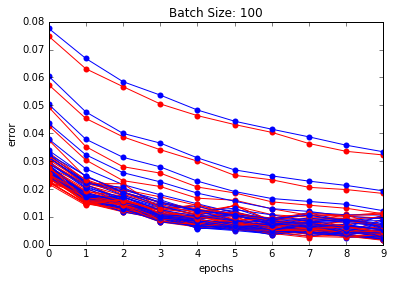

In [11]:
hype_results = []
batch = 100
etas = np.linspace(0.00015, 0.0060, 40)

plt.figure(figsize=(6, 4))

for ind, eta in enumerate(etas):
    result = batch_Adam(batch, eta, verbose=False)
    
    hype_results.append({"eta": eta, "result": result})
    plot_result(result, show_legend=False)

plt.title('Batch Size: {}'.format(batch))
plt.show()

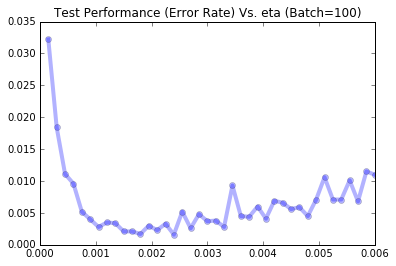

In [12]:
plt.figure(figsize=(6, 4))
plt.title('Test Performance (Error Rate) Vs. eta (Batch=100)')
plt.plot(map(lambda result: result['eta'], hype_results), 
         map(lambda result: 1 - result['result'][3][-1], hype_results),
         'bo-', linewidth=4, alpha=0.3)
plt.show()

from the plot above, we conclude that the best pick of eta for `batch=100` is around 0.0018.

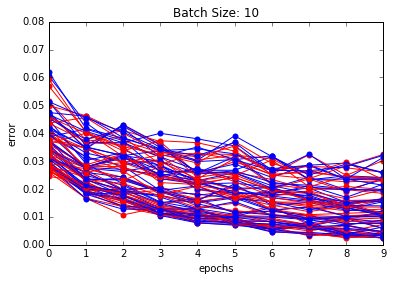

In [13]:
hype_results = []
batch = 10
etas = np.linspace(0.00015, 0.0060, 40)

plt.figure(figsize=(6, 4))

for ind, eta in enumerate(tqdm(etas)):
    result = batch_Adam(batch, eta, verbose=False)
    
    hype_results.append({"batch": batch, "eta": eta, "result": result})
    plot_result(result, show_legend=False)

plt.title('Batch Size: {}'.format(batch))
plt.show()

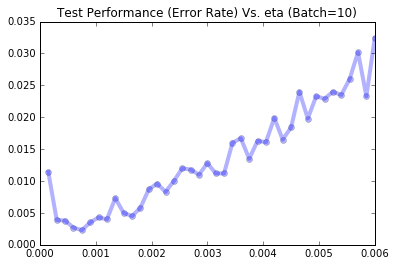

In [14]:
plt.figure(figsize=(6, 4))
plt.title('Test Performance (Error Rate) Vs. eta (Batch=10)')
plt.plot(map(lambda result: result['eta'], hype_results), 
         map(lambda result: 1 - result['result'][3][-1], hype_results),
         'bo-', linewidth=4, alpha=0.3)
plt.xlim(0, 0.006)
plt.show()

from the plot above, we conclude that the best pick of eta for `batch=10` is around 0.00075.